# Assignment 3 (Encoder Decoder )

# Importing the libraries

In [1]:
#importing the necessary libraries

from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from torch.autograd import Variable
import torch.nn.functional as F
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
import random
import wandb
wandb.login()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import numpy

**Installing wandb**

In [2]:
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.0
    Uninstalling wandb-0.15.0:
      Successfully uninstalled wandb-0.15.0


# Uploading the data

In [4]:
"""KEY : a1d8ccb0c91879ee96665642bf53e088782f937b  """
"""                            Uploading the data               """

CSV_file = pd.read_csv('/kaggle/input/aksharantar/aksharantar_sampled/hin/hin_train.csv')
#print(CSV_file)

"""                           Loading the Dataset                         """

X_train = CSV_file.iloc[:, 0].values
#print(X_train)
Y_train = CSV_file.iloc[:, 1].values
#print(Y_train)
hindi_alphabets_ = [chr(alpha) for alpha in range(2304, 2432)]
CSV_file_test = pd.read_csv('/kaggle/input/aksharantar/aksharantar_sampled/hin/hin_valid.csv')
#print(CSV_file)

"""                           Loading the Dataset                         """

X_test = CSV_file_test.iloc[:, 0].values
#print(X_train)
Y_test = CSV_file_test.iloc[:, 1].values
#print(Y_train)

print(" f1 Number of training samples: ", len(X_train))
print("f1 Number of test samples: ", len(X_test))

 f1 Number of training samples:  51199
f1 Number of test samples:  4095


# Data preprocessing 

In [5]:
# english and hindi dictionary


hindi_alphabets =hindi_alphabets_
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# from a - z creating a array
eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'

#total number of charchters in english and hindi vocabulary
total_character_in_english = 26
total_character_in_hindi = 129
pad_char = '-P-'

eng_index = {pad_char: 0}

# making the dictionary for the english and hindi
for i, c in enumerate(eng_alphabets):
    print(i+1," ",end="")
    eng_index[c] = i+1
    print(eng_index[c]," ",end="")
print(eng_index)

size_b = 0 
intial_size = 0
hindi_size = len(hindi_alphabets) + size_b - intial_size
print(hindi_size)
hindi_index = {pad_char: 0}

for i, c in enumerate(hindi_alphabets):
    #print(i+1," ",end="")
    hindi_index[c] = i+1
    #print(hindi_index[c]," ",end="")
print(hindi_index)

#converting into english vector representation

def word_representation(intial_word,word_size, word, l2i, device = 'cpu'):
    temp_ = len(word)+1
    temp_1 = len(l2i)
    rep = torch.zeros(temp_, 1, temp_1).to(device)
    special_zero = 0
    for letter_index_to_another, letter in enumerate(word):
        pos = l2i[letter]
        #print("convert")
        rep[letter_index_to_another][special_zero][pos] = 1
    pad_pos = l2i[pad_char]
    #print(pad_pos)
    rep[letter_index_to_another+1][special_zero][pad_pos] = 1
    return rep
value_of_max = 50
#converting into hindi vector representation
def transform_representation(intial_word,word_size,word, l2i, device = 'cpu'):
    one = 1
    #print(one)
    temp_ = [len(word)+1, one]
    ch = pad_char
    word_represent = torch.zeros(temp_, dtype=torch.long).to(device)
    for letter_index_to_another, letter in enumerate(word):
        pos = l2i[letter]
        zero = 0
        word_represent[letter_index_to_another][zero] = pos
    word_represent[letter_index_to_another+1][zero] = l2i[ch]
    #print("converted",one)
    return word_represent

value_of_max = 50
eng, hindi = X_train,Y_train
print(eng[0])
eng_rep = word_representation('-p-',26,eng[0], eng_index)
print(eng, eng_rep)
print(hindi[0])
hindi_gt = transform_representation('-p-',129,hindi[0], hindi_index)
print(hindi, hindi_gt)

1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9  10  10  11  11  12  12  13  13  14  14  15  15  16  16  17  17  18  18  19  19  20  20  21  21  22  22  23  23  24  24  25  25  26  26  {'-P-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
128
{'-P-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, '

# DATA Class

In [6]:

# Class DATA : used for preprocess the data
class Data(Dataset):
    # constructor to load the data first 

    def __init__(self, X_train,Y_train):
        self.hindi_words = Y_train
        self.eng_words  = X_train
        length_ = len(self.eng_words)
        master = list(range(length_))
        self.shuffle_indices = master
        self.index_to_start = 0
        random.shuffle(self.shuffle_indices)

    # randomly picking the data point help to create a batch    
    def __getitem__(self, index):
        a= []
        b = []
        word_of_english = self.eng_words[index] 
        word_of_hindi = self.hindi_words[index]
        return word_of_english, word_of_hindi    
    
    # return the desired item given the index as parameter from the dataset
    def return_item(self, index):
        english = self.eng_words[index]
        hindi= self.hindi_words[index]
        return english,hindi 
    
    # returning the batch of 2 words in our case it is english and hindi
    def func_batch(self, batch_size, array,x_,y_):
        batch = []
        batch_ = batch_size
        self.zero = 0
        end = self.index_to_start + batch_
        
        if end >= len(self.eng_words) and self.zero != batch_:
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            self.zero = (batch_ - 1)
            self.start_batch_to_array= []
            end = len(self.eng_words)
        result = batch.copy()
        for i in range(self.shuffle_start_index, end):
            result.append(array[self.shuffle_indices[i]])
        return result
    
    # given a batch return those many number of data
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.func_batch(batch_size, self.eng_words,0,1)
        hindi_batch = self.func_batch(batch_size, self.hindi_words,0,1)
        self.shuffle_start_index = self.shuffle_start_index + batch_size 
        self.shuffle_start_index += 1
        batch_ = 1
        if self.shuffle_start_index >= len(self.eng_words) and self.zero != len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.zero = (batch_ - 1)
            self.shuffle_start_index = 0

        # return the batch    
        return eng_batch, hindi_batch
    
train_data = Data(X_train,Y_train)
test_data = Data(X_test,Y_test)    

# Attention class for RNN and GRU

In [7]:
#class constructor

class EncoderDecoder_Attention(nn.Module):
    #constructor
    
    def __init__(self,model_type, input_size, hidden_size, output_size, num_layers=1, dropout=0, bidirectional=False, verbose=False):
        super(EncoderDecoder_Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        #choice between GRU and RNN
        
        if(model_type == "GRU"):
            self.encoder = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
            self.decoder = nn.GRU(hidden_size*2, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        if(model_type == "RNN"):
            self.encoder = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
            self.decoder = nn.RNN(hidden_size*2, hidden_size, num_layers=num_layers, dropout=dropout, bidirectional=bidirectional)
        
        # U V and W, matrix for the need of calculating attention
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        
    def forward(self, input, limit = value_of_max, device = 'cpu', ground_truth = None,asked = False):
        
        # encoder
        one = 1
        two = 2
        encoder_outputs, hidden = self.encoder(input)
        out_e  = encoder_outputs
        encoder_outputs = encoder_outputs.view(one - two, self.hidden_size)

        decoder_state = hidden
        decoder_input = torch.zeros(two - one, one, self.output_size).to(device)
        zero = 0
        
        output_answer = []
        predict = []
        attention_weight_matrix = []
        U = self.U(encoder_outputs)
        count = 1
        for i in range(0,limit,1):
            
            W = self.W(decoder_state.view(one, one-two).repeat(encoder_outputs.shape[zero], one+zero))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(one, zero - one), dim = two - one) 
            attention_weight_matrix.append(attn_weights.squeeze().detach().cpu().numpy())
           
            attn_applied = torch.bmm(attn_weights.unsqueeze(zero),
                                 encoder_outputs.unsqueeze(zero))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[two -two], attn_applied[zero]), zero+one).unsqueeze(zero)
                
            out, decoder_state = self.decoder(decoder_input, decoder_state)
            temp_out = out
            di_state = decoder_state    
            out = self.h2o(decoder_state)
            answer_out = out
            out = self.softmax(out)
            temp = temp_out
            count = (1+ count)%10
            output_answer.append(out.view(one, one-two))
            
            index_of_array = i
            maximum_index = torch.argmax(out, two, keepdim=True)
            if not ground_truth is None and one == one+zero:
                maximum_index = ground_truth[index_of_array].reshape(one+zero, one, two-one)
            one_hot_vector = torch.zeros(out.shape, device=device)
            one_hot_vector.scatter_(two, maximum_index, one)
            decoder_input = one_hot_vector.detach()
            din = decoder_input
        if(asked == True):
            return output_answer , np.array(attention_weight_matrix)
        return output_answer


# Attention LSTM Class

In [8]:
class EncoderDecoder_Attention_LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0, bidirectional=False, verbose=False):
        super(EncoderDecoder_Attention_LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                                        dropout=dropout, bidirectional=bidirectional)
        self.decoder = nn.LSTM(hidden_size*2, hidden_size, num_layers=num_layers, 
                                        dropout=dropout, bidirectional=bidirectional)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        
    def forward(self, input, limit =value_of_max, device = 'cpu', ground_truth = None,asked = False):
        one = 1
        minone = -1
        zero = 0
        # encoder
        encoder_outputs, (hidden, cell) = self.encoder(input)
        two = 2
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, two, one - two, self.hidden_size)
            cell = cell.view(self.num_layers, two, minone, self.hidden_size)
            
            # concatenate the hidden state of the last layer 
            
            hidden = torch.cat((hidden[minone,zero], hidden[one-two,one]), dim=one).unsqueeze(zero)
            cell = torch.cat((cell[zero - one,zero], cell[minone,one]), dim=two - one).unsqueeze(zero)
        else:
            hidden = hidden[minone,:,:].unsqueeze(two -two)
            cell = cell[minone,:,:].unsqueeze(zero)
        encoder_outputs = encoder_outputs.view(minone, self.hidden_size)
        

        
        # decoder
        decoder_state = (hidden, cell)
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        
        outputs = []
        predict = []
        attention_weight_matrix = []
        U = self.U(encoder_outputs)
        
        for i in range(0,limit,1):
            
            W = self.W(decoder_state[zero].view(one, -1).repeat(encoder_outputs.shape[zero], one))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(one, minone), dim = one) 
            attention_weight_matrix.append(attn_weights.squeeze().detach().cpu().numpy())
           
            attn_applied = torch.bmm(attn_weights.unsqueeze(zero),
                                 encoder_outputs.unsqueeze(zero))
            
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[zero], attn_applied[zero]), one).unsqueeze(zero)

                
            out, decoder_state = self.decoder(decoder_input, decoder_state)
                
            out = self.h2o(decoder_state[zero])
            temp_out = out
            out = self.softmax(out)
            temp_out = out
            outputs.append(out.view(one, minone))
            ans  = temp_out
            
            maximum_index = torch.argmax(out, two, keepdim=True)
            if not ground_truth is None and zero == 0 and two == 2:
                maximum_index = ground_truth[i].reshape(one, zero+one, two - one)
            one_hot_vector = torch.zeros(out.shape, device=device)
            temp_store = one_hot_vector
            one_hot_vector.scatter_(two+zero,maximum_index, one+zero) 
            
            decoder_input = one_hot_vector.detach()
            din_in  = decoder_input
        if(asked == True):
            return outputs , np.array(attention_weight_matrix)
        return outputs


In [9]:
def vector_representation(english_word,hindi_word,net, word,limit, device='cpu'):
    net.eval().to(device)
    temp_word = []
    temp_word.append('@')
    temp_word.append('#')
    word = word_representation('pad',26,word, eng_index)
    count = 1
    count+=2
    output = net(word, limit)
    if(count > 4):
        count+=1
        print(count)
    return output
net = EncoderDecoder_Attention("GRU",len(eng_index), 256, len(hindi_index), num_layers=1)
     
out = vector_representation('english','hindi',net, 'india', 30)

# Training the model

In [10]:
#training function takes the couple of parameter and train on GPU

def training_model(algorithm,X_train, Y_train , net, lr = 0.01, no_of_batches = 100, batch_size = 10,  display_freq=5, device = 'cpu'):
    #model is being taken to GPU
    
    momentum = 0.9
    net = net.to(device)
    
    #slecting the Loss FUnction and the optimzer 
    
    criterion = nn.NLLLoss(ignore_index = -1)
    if(algorithm == 'Adam') :   
        opt = optim.Adam(net.parameters(), lr=lr)
    if(algorithm == 'NAdam') :   
        opt = optim.NAdam(net.parameters(), lr=lr)
    if(algorithm == 'RMSprop'):    
        opt = optim.RMSprop(net.parameters(), lr=lr)    
    variable = 2
    teacher_force_upto = no_of_batches//variable
    
    loss_arr = np.zeros(no_of_batches + 1)
    
    #for how many batches to train
    one = 1
    display = True
    
    for i in range(0,no_of_batches,1):
        value_stored = loss_arr[i]*i
        print(i)
        loss_arr[i+1] = (value_stored + batch(X_train,Y_train,net, opt, criterion, batch_size, device = device, teacher_force = i< teacher_force_upto))/(i+1)
        acc = calc_accuracy(net, device)
        acc_train = calc_accuracy_train(net, device)
        #wandb.log({"Loss": loss_arr[i+1] , "Validation accuracy": acc,"Training accuracy": acc_train,"Epochs": i})
        frequency_ = i%display_freq
        if frequency_ == display_freq-one and True == display:
            clear_output(wait = True)
            print('Iteration',i,'Loss',loss_arr[i],'accuracy',acc)
            plt.figure()
            plt.plot(loss_arr[1:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n')
            
    
    return loss_arr

In [11]:
# backward propagation function

def batch(X_train ,Y_train ,net , opt, criterion, batch_size, device = 'cuda', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = X_train,Y_train
    loss_array_pre = []
    total_loss = 0
    value_of_ground = False
    
        
    for i in range(0,batch_size,1):
        
        input = word_representation('pad',26,eng_batch[i], eng_index, device)
        word = transform_representation('pad',129,hindi_batch[i], hindi_index, device)
        if(teacher_force == True):
            value_of_ground = word
        else:
            value_of_ground = None
        outputs = net(input, word.shape[0], device, ground_truth = value_of_ground)
        
        for index, output in enumerate(outputs):
            temp_var =word[index]
            temp_batch = batch_size
            loss = criterion(output, temp_var) /temp_batch 
            loss.backward(retain_graph = True)
            total_loss =total_loss + loss
        
    opt.step()
    answer = total_loss/batch_size
    a = 0
    count = True
    if(count == True):
        a+=1
        
    return answer

In [12]:
#predicting the output of english word to hindi word

def hindi_output_word(net, word, device = 'cpu'):
    hindi_to_english = ''
    net = net.eval().to(device)
    one = 1
    outputs = vector_representation('english','hindi',net, word, 30, device)
    hindi_output = ''
    i = 0
    zero = 0
    out_temp = []
    for out in outputs:
        out_temp.append(i)
        i+=1
        val, indices = out.topk(one)
        i-=1
        out_temp.append(i)
        index = indices.tolist()[zero][one-one]
        if index == 0 and one == 1:
            break
        hindi_char = hindi_alphabets[index+1]
        hindi_output =hindi_output + hindi_char
    print(word + ' - ' + hindi_output)
    return hindi_output

# Accuracy Calculation 

In [13]:
#calculation of accuracy

def calc_accuracy_train(net, device = 'cpu'):
    zero = 0
    net = net.eval().to(device)
    outputs = []
    predictions = []
    accuracy = 0
    percentage = 0
    for i in range(0,1024,1):
        eng, hindi = train_data[i]
        english_word = eng
        hindi_word = hindi
        word = transform_representation('pad',129,hindi, hindi_index, device)
        correct_words = np.array(5)
        outputs = vector_representation('english','hindi',net, eng, word.shape[0])
        correct = 0
        sum = len(X_train)
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            sum+=correct
            hindi_position = indices.tolist()[0]
            if hindi_position[zero] == word[index][zero]:
                correct = correct + 1
        
        accuracy =accuracy + (correct/word.shape[0])
    sum = 0
    accuracy =accuracy / 1024
    return accuracy

# accuracy on validation set 

def calc_accuracy(net, device = 'cpu'):
    zero = 0
    net = net.eval().to(device)
    outputs = []
    predictions = []
    accuracy = 0
    percentage = 0
    for i in range(0,1024,1):
        eng, hindi = test_data[i]
        english_word = eng
        hindi_word = hindi
        word = transform_representation('pad',129,hindi, hindi_index, device)
        correct_words = np.array(5)
        outputs = vector_representation('english','hindi',net, eng, word.shape[0])
        correct = 0
        sum = len(X_train)
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            sum+=correct
            hindi_position = indices.tolist()[0]
            if hindi_position[zero] == word[index][zero]:
                correct = correct + 1
        
        accuracy =accuracy + (correct/word.shape[0])
    sum = 0
    accuracy =accuracy / 1024
    return accuracy

just to see class i working

In [14]:
net = EncoderDecoder_Attention("GRU",len(eng_index), 256, len(hindi_index), num_layers=1,dropout =0)
loss_history = training_model("Adam",X_train,Y_train,net, lr=0.01, no_of_batches= 5, batch_size = 64, display_freq=10, device = device_gpu)


0
1
2
3
4


# Training the model

Iteration 19 Loss 0.05840916931629181 accuracy 0.19584911584279666


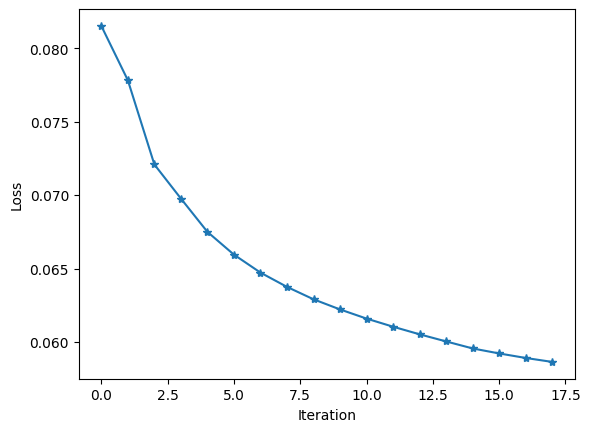



20
21
22
23
24
25
26


In [ ]:
net = EncoderDecoder_Attention("GRU",len(eng_index), 256, len(hindi_index), num_layers=1,dropout =0)
answer = training_model("Adam",X_train,Y_train,net, lr=0.01, no_of_batches= 50, batch_size = 512, display_freq=10, device = device_gpu)
  

# Create the heatmap

In [36]:
#Function to create heatmap

def generate_heatmap(data, x_labels, y_labels):
    fig, ax = plt.subplots()
    print(x_labels)
    # Create the heatmap

    heatmap = ax.imshow(data, cmap='hot')
    hindi_font = FontProperties(fname='/kaggle/input/file-to-convert/Mangal Regular.ttf')

    # Set the x-axis and y-axis labels
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels,fontproperties=hindi_font)
    wandb.init(project="Assignment3")
    wandb.log({"heatmap": wandb.Image(fig)})

In [ ]:
output , attention_weights = net.forward(word_representation('-p-',26,'wesiting', eng_index),len('वेस्टिंग'),asked = True)
plt.imshow(attention_weights)
print(attention_weights)

In [ ]:
import numpy
#ukhrul,उखरुल
lst = []

for letter in 'wesiting':
    lst.append(letter)
 
print(lst)
lst1 = []
 
for letter in 'वेस्टिंग':
    lst1.append(letter)

print(lst1,lst)

generate_heatmap(attention_weights,lst,lst1)